# Метод Монте-Карло в физике

Методами Монте-Карло называют множество различных методов в совершенно разных областях от физики до экономики. Основная суть этих методов заключается в использовании случайных величин для получения различных состояний исследуемой системы. 

Одно из частых применений метода Монте-Карло в физике состоит в расчете интегралов. При этом действительно полезным и незаменимым метод становится при работе с большим количеством измерений, когда построение обычных квадратур приводит к чересчур  огромным сеткам. Например, уже в случае 10 измерений, задание обычной равномерной решетки шириной в $2^4 = 16$ узлов, приводит к общей сетке размера $2^{40} \simeq 10^{12}$. Массив данных float такого размера будет занимать 4ТБ в памяти компьютера. Оперировать такими интегралами стандартными методами становится принципиально невозможно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
plt.style.use('ggplot')
%matplotlib notebook

## Задание 1
Вычислим объем многомерной сферы в большом количестве измерений.

### Задание 1.1 
Напишите функцию, вычисляющую точный объем $d$-мерной сферы с помощью явного выражения. 
Объем многомерной сферы радиуса $R$ в $d$-измерениях дается формулой: 
$$
V_d = \frac{\pi^{d/2}} {\Gamma(1 + d/2)} R^d
$$
где $\Gamma(x)$ - гамма функция, значение которой можно получить из scipy.special.

In [2]:
def getSphereVolumeExact(D, R = 1.0):
    """
    Функция вычисляет значение объема D-мерной сферы радиуса R по явной формуле

    --------
    Аргументы:
    D - int, количество измерений 
    R = 1 - float, радиус сферы
    --------
    Функция возвращает:
    V - float, объем сферы
    """
    D = float(D)
    
    V = np.pi**(D/2) * R**D / sp.gamma(1 + D/2)
    
    return V

1. Проверьте результат для нескольких известных вам значений. 
2. Построите график V(D)

Посчитанный ответ для d=2:  3.141592653589793 ; Истинное значение:  3.141592653589793
Посчитанный ответ для d=3:  4.188790204786391 ; Истинное значение:  4.1887902047863905


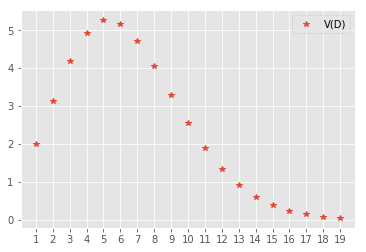

In [3]:
# Write your code and answer here
print('Посчитанный ответ для d=2: ', getSphereVolumeExact(2), '; Истинное значение: ', np.pi) # площадь в двумерии, должно выдасть Pi
print('Посчитанный ответ для d=3: ', getSphereVolumeExact(3), '; Истинное значение: ', 4*np.pi/3) # объем шара в 3d, будет 4Pi/3

X = np.arange(1, 20)
Y = np.zeros_like(X, dtype=np.float)
for d in X:
    Y[d-1] = getSphereVolumeExact(d)

plt.plot(X, Y, '*', label='V(D)')
plt.xticks(np.arange(1, 20, step=1))
plt.legend()
plt.show()


### Задание 1.2
Напишите функцию, вычисляющую объем сферы методом Монте-Карло на псевдослучайных числах (используя, например `numpy.random.rand`).

In [4]:
def getSphereVolumePseudorandom(N, D, R = 1, seed=1):
    """
    Функция вычисляет значение объема D-мерной сферы радиуса R методом Монте-Кало на псевдослучайных числах

    --------
    Аргументы:
    N - int, количество случайных точек
    D - int, количество измерений 
    R = 1 - float, радиус сферы
    --------
    Функция возвращает:
    V - float, объем сферы
    """
    np.random.seed(seed)   # чтобы каждый раз была не разная выборка
    points = np.random.uniform(size=(N, D))   # генерируем N точек, координаты [0, 1) (!), но т.к. в задаче можно выбрать только часть области, ничего плохого не случится
    
    V_sq = (2*R)**D   # объем d-мерного куба со стороной 2R
    
    def isInside(q, R):
        r = (np.sum(q**2, axis=1))**0.5   # возводим в квадрат все координаты, а затем суммируем по строке, так как в строке расположены координаты одной точки
        return (r <= R).astype(int)       # массив 0 и 1, в зависимости от того попала ли точка в шар
        
    Count = np.count_nonzero(isInside(points, R))    # кол-во попавших в область точек
    
    V = V_sq * Count / N   # часть от точек * объем гиперкуба
    
    return V

Постройте график зависимости относительной точности $\epsilon$ которая достигается при фиксированном $N$ от размерности сферы $D$. Для относительной погрешности используйте выражение $\epsilon = (V_{exact} - V_{random})/V_{exact}$.

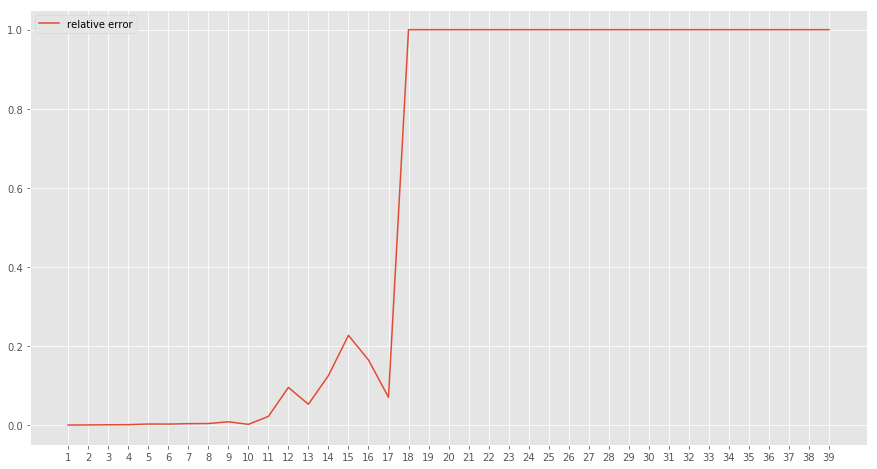

In [5]:
# Write your code and answer here
D = np.arange(1, 40)
Y_pseud = np.zeros(D.shape[0])
N = 1000000

for d in D:
    V_exact = getSphereVolumeExact(d)
    V_random = getSphereVolumePseudorandom(N, d, seed=0)
    
    Y_pseud[d-1] = np.abs(V_exact - V_random) / V_exact    # считаем относительную ошибку

plt.figure(figsize=(15,8))
plt.plot(D, Y_pseud, label='relative error')
plt.xticks(np.arange(1, 40, step=1))
plt.legend()
plt.show()

Начиная с ~10-мерия, для N=1e6, точек уже не хватает в нужной области, и значение скатывается до 0 уже в 18-мерии, т.к. там ни одна точка в область не попала; давайте посмотрим ошибку от для d от 1 до 10; в дальнейшем для Соболя мы тоже будем смотреть только первые ~10 измерений, т.к. там тоже перестаёт хватать точек(а время выполнения с ростом N растет для Соболя еще сильнее)

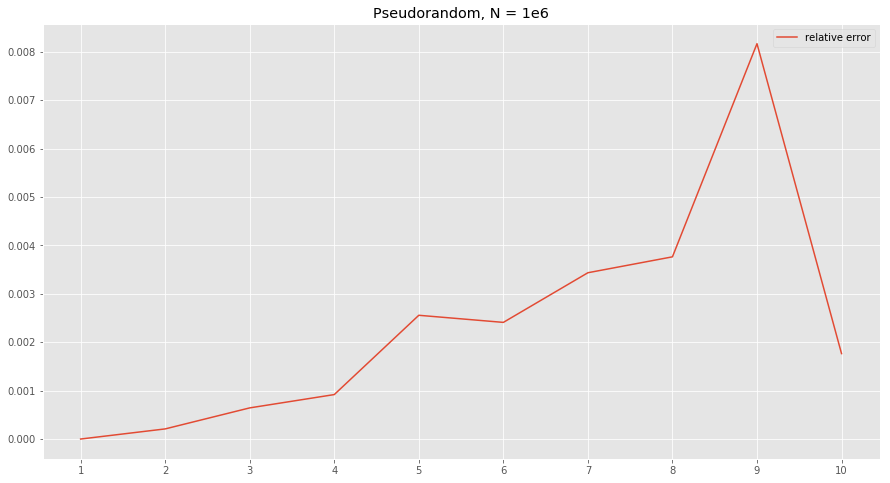

In [6]:
D = np.arange(1, 11)
Y_pseud = np.zeros(D.shape[0])
N = 1000000

for d in D:
    V_exact = getSphereVolumeExact(d)
    V_random = getSphereVolumePseudorandom(N, d, seed=0)
    
    Y_pseud[d-1] = np.abs(V_exact - V_random) / V_exact

plt.figure(figsize=(15,8))
plt.plot(D, Y_pseud, label='relative error')
plt.xticks(np.arange(1, 11, step=1))
plt.legend()
plt.title('Pseudorandom, N = 1e6')
plt.show()

### Задание 1.3
Напишите функцию, вычисляющую объем сферы методом Монте-Карло на квазислучайной последовательности Соболя.

Для установки библиотеки `sobol_seq`:


выполните `pip install sobol_seq` в Jupyter или

выполните команду `pip install sobol_seq --user` в командном окне (если вы используете Jupyter Notebook в составе Anaconda откройте Anaconda Prompt и выполните команду pip в ней, после чего перезапустите Jupyter Notebook).


In [7]:
#!pip install sobol_seq # <-- uncomment to install sobol_seq
import sobol_seq

Используйте функцию `i4_sobol_generate`. Документацию по ней можно получить выполнив следующую строчку кода:

In [87]:
sobol_seq.i4_sobol_generate?

In [8]:
def getSphereVolumeQuasirandom(N, D, R = 1):
    """
    Функция вычисляет значение объема D-мерной сферы радиуса R методом Монте-Кало на квазислучайных числах

    --------
    Аргументы:
    N - int, количество случайных точек
    D - int, количество измерений 
    R = 1 - float, радиус сферы
    --------
    Функция возвращает:
    V - float, объем сферы
    """
    points = sobol_seq.i4_sobol_generate(D, N)   # генерируем N точек, координаты [0, 1) (!), но т.к. в задаче можно выбрать только часть области, ничего плохого не случится
    
    V_sq = (2*R)**D   # объем d-мерного куба со стороной 2R
    
    def isInside(q, R):
        r = (np.sum(q**2, axis=1))**0.5   # возводим в квадрат все координаты, а затем суммируем по строке, так как в строке расположены координаты одной точки
        return (r <= R).astype(int)       # массив 0 и 1, в зависимости от того попала ли точка в шар
        
    Count = np.count_nonzero(isInside(points, R))    # кол-во попавших в область точек
    
    V = V_sq * Count / N   # часть от точек * объем гиперкуба
    
    return V

Сравните точность вычисления объема для квазислучайной и псевдослучайной последовательностей, рассчитав  $\epsilon(D)$, при таком же значении $N$, как в предыдущем задании. Постройте обе зависимости $\epsilon(D)$ на одном графике в логарифмической шкале по $\epsilon$.

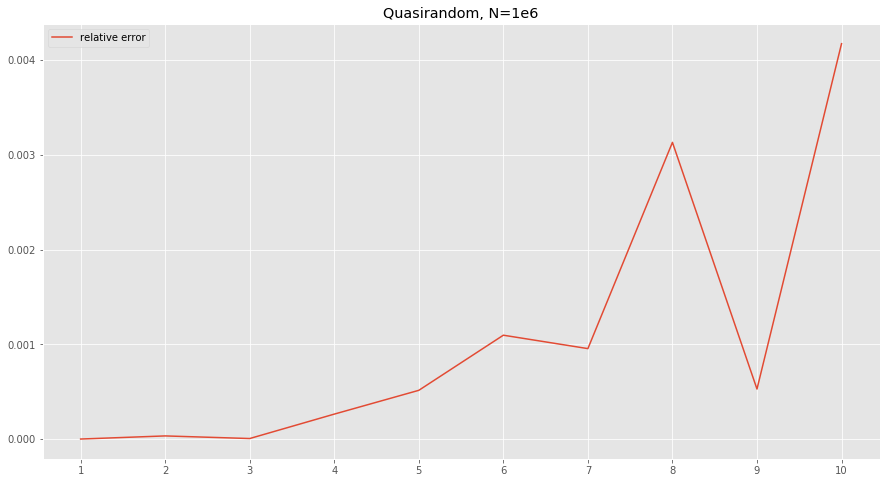

In [9]:
# Write your code and answer here

Y_quasi = np.zeros(D.shape[0])

for d in D:
    V_exact = getSphereVolumeExact(d)
    V_random = getSphereVolumeQuasirandom(N, d)
    
    Y_quasi[d-1] = np.abs(V_exact - V_random) / V_exact      # блок работает не быстро, совсем

plt.figure(figsize=(15,8))
plt.plot(D, Y_quasi, label='relative error')
plt.xticks(np.arange(1, 11, step=1))
plt.legend()
plt.title('Quasirandom, N=1e6')
plt.show()

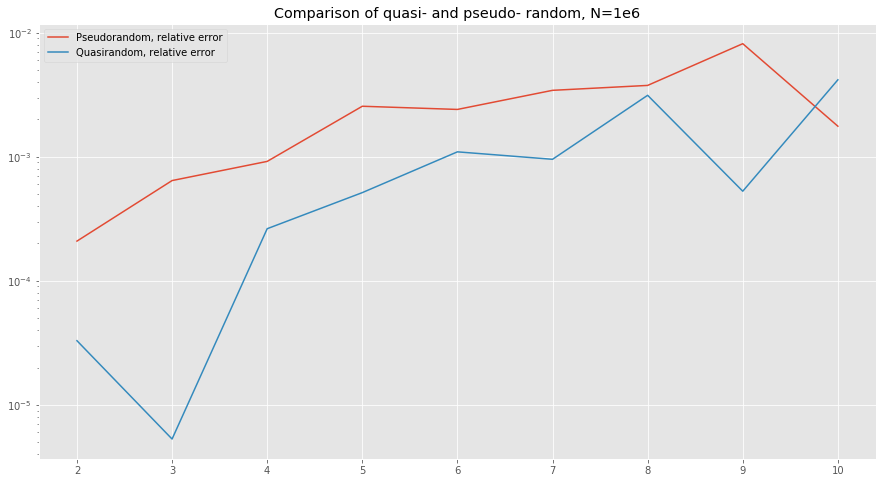

In [10]:
D = np.arange(2, 11)
plt.figure(figsize=(15,8))
plt.yscale('log')
plt.plot(D, Y_pseud[1:], label='Pseudorandom, relative error')
plt.plot(D, Y_quasi[1:], label='Quasirandom, relative error')
plt.xticks(np.arange(2, 11, step=1))
plt.legend()
plt.title('Comparison of quasi- and pseudo- random, N=1e6')
plt.show()

Сделайте вывды о работе псевдослучайной и квазислучайной последовательностях. 

В среднем, квазирандомная последоательность справляется с задачей лучше, т.к. более равномерно замощает пространство

## Задание 2

Рассмотрим решетку $n\times n$, в которой каждой ячейке соответствует спин $\sigma_i$ равный $+1$ или $-1$. При этом между соседними ячейками существует энергия взаимодействия
$$
E_i = -J \sigma_i \sigma_j
$$
Тогда энергия каждой ячейки 
$$
E_i = -J \sigma_i \sum_j \sigma_j
$$
где суммирование подразумевается только по соседним с $i$-ой ячейкой.

При нулевой температуре энергитически более выгодным состоянием является состояние, когда все спины одинаково ориентированы. Однако при ненулевой температуре вероятность перехода в более возбужденное состояние пропорциональна $\sim \exp(-\Delta E/ k T)$.

Явное численное моделирование такой системы (модели Изинга) является проблематичным, поскольку количество возможных состояний системы $2^N$, где $N$ - общее число узлов, и уже для двумерной сетки $16\times 16$ это число становится астрономически большим. 

На помощь приходят методы Монте-Карло. Одна из простейших его реализаций (алгоритм Метрополиса — Гастингса):
1. Задаем случайное начальное состояние
2. Выбираем случайную ячейку
3. Переворачиваем её спин и считаем изменение энергии $\delta E$ данной ячейки.
4. Если изменение энергии отрицательное, оставляем спин перевернутым
5. Если изменение энергии положительное, оставляем спин перевернутым с вероятностью $\exp(-\delta E/kT)$
6. Повторяем пункты 2-5 нужное количество раз

Спустя достаточно большое количество повторений устанавливается равновесное состояние. 

Реализуем данный алгоритм: 
1. Задайте начальное случайное расраспределение в виде матрицы из $+1$ и $-1$ размерности $N\times N$:

In [11]:
def getInitialState(N, seed=False):
    '''
    Функция задает случайное начальное состояние
    ---------
    Аргументы:
    N - int, линейный размер решетки 
    --------
    Функция возвращает:
    state - numpy ndarray of ints, массив состояния системы размера NxN
    '''
    if seed:
        np.random.seed(777)    # чтобы не 
    
    Rand = np.random.rand(N, N)
    Bool = (Rand < 0.5)
    
    state = np.array(Bool.astype(int) * 2 - 1)
    
    return state

2. Напишите функцию, которая для ячейки $(i,j)$ расчитывает изменение её энергии, если изменить её знак. При этом для простоты предполагаем, во-первых, что $J=1$ (на него отнормируем kT), и во-вторых, что элементы находящиеся на верхней и нижней (левой и правой) границах находятся рядом друг с другом (топология тора).  


In [12]:
def getDeltaE(i, j, state):
    '''
    Функция расчитывает и возвращает изменение энергии ячейки (i,j) в случае ее переворота (не меняя состояния state)
    
    ---------
    Аргументы:
    i - int, адресс ячейки вдоль оси 0
    j - int, адресс ячейки вдоль оси 1
    state - numpy ndarray of ints, массив состояния системы размера NxN
    --------
    Функция возвращает:
    dE - float, изменение энергии
    '''
    E = np.zeros(4)   # тут будет храниться энергия взаимодействия ячейки с 4 соседями: up, right, down, left, то есть пробегается по часовой стрелке вокруг
    
    E[0] = - state[i, j] * state[i-1, j]   # с верхним и левым легко расправиться, даже если i==0 или j==0, топология тора будет работать
    E[3] = - state[i, j] * state[i, j-1]
    
    if j == N-1:
        E[1] = - state[i, j] * state[i, 0]             # 2 случая для соседа справа
    else:
        E[1] = - state[i, j] * state[i, j+1]
    
    if i == N-1:
        E[2] = - state[i, j] * state[0, j]             # 2 случая для соседа снизу
    else:
        E[2] = - state[i, j] * state[i+1, j]
    
    
    E_cell = np.sum(E)
    # т.к. при перевороте ячейки, во всей сумме state[i,j] меняет знак, то после переворота E_cell -> -E_cell, тогда dE = -2 * E_cell
    dE = -2 * E_cell
    
    return dE

3. Напишите функцию, которая $N^2$ раз для разных случайных $(i,j)$ меняет спин в зависимости от изменения энергии, согласно пунктам 4. и 5. 

In [13]:
def makeFlip(T, state):
    '''
    Функция N^2 раз переворачивает спин, и принимает решение оставить его перевернутым или нет, согласно правилам 4. и 5.
    
    ---------
    Аргументы:
    T - float, положительное число, безразмерный коэфициент, характеризующий температуру, равный kT/J
    state - numpy ndarray of ints, массив состояния системы размера NxN
    --------
    Функция возвращает:
    state - numpy ndarray of ints, массив нового состояния системы размера NxN
    '''
    state = np.array(state)
    N = state.shape[0]
    
    # создадим массив 2 x N**2, в котором будет храниться информация, какие именно ячейки переворачивать
    
    Permutations = np.random.randint(N, size=(2, N**2))   # randint генерирует целые числа из промежутка [0, N)
    
    for k in range(N**2):
        x, y = Permutations[:, k]
        dE = getDeltaE(x, y, state)
        if dE < 0:
            state[x, y] *= -1     #если выгодно - меняем
        
        if dE > 0:
            if np.random.uniform() < np.exp(-dE/T):    # если невыгдно, то с вероятностью exp(-dE/kT) меняем, для этого генерируем случайное число от 0 до 1, и смотрим куда попало число, если оно меньше exp(.), то меняем;
                state[x, y] *= -1
    
    
    return state

4. Напишите функцию, которая будет рассчитывать значение энергии всей системы (предполагаем $J=1$).

In [14]:
def getEnergy(state):
    '''
    Функция, рассчитывает значение энергии всей системы
    ---------
    Аргументы:
    state - numpy ndarray of ints, массив состояния системы размера NxN
    --------
    Функция возвращает:
    E - float, значение энергии системы
    '''
    # тут можно схитрить, использовав нашу функцию getDeltaE, т.к. мы знаем, что она выдаёт -2 * E_cell, то есть нам нужно
    # просто посчитать getDeltaE для ячейки, разделить на (-2) и просуммировать по ячейкам. Надо также разделить это на 2,
    # т.к. иначе мы каждую энергию взаимодействия дважды просуммируем
    state = np.array(state)
    E = 0.
    N = state.shape[0]
    
    for i in range(N):
        for j in range(N):
            E += getDeltaE(i, j, state) / (-2)
    E /= 2
    
    return E

5. Напишите функцию, которая будет рассчитывать значение намагниченности всей системы $M=\sum \sigma$

In [15]:
def getMagnetization(state):    
    '''
    Функция, рассчитывает значение намагниченности всей системы
    ---------
    Аргументы:
    state - numpy ndarray of ints, массив состояния системы размера NxN
    --------
    Функция возвращает:
    M - float, значение намагниченности системы
    '''
    M = np.sum(state)
    return M

В следующей ячейке кода зададим начальные параметры: 

**Nt** - количество точек по температуре, 

**N** - линейный размер решетки, 

**eqStep** - количество попыток переворота спина, в течение которых система приводится к равновесному сосотоянию. Обратите внимание, что это число должно увеличиваться пропорционально размеру всей сетки,

**steps** - количество попыток переворота спина, в течение которых рассчитывается значения энергии и намагниченности (нужно для усреднения расчитанных значений по ансамблю состояний, близких к равновесному)

In [16]:
N       = 6         # размер решетки NxN
Nt      = 30         # количество точек температуры
eqSteps = 2000        # количество раз выполнения makeFlip для установления равновесия
steps   = 50         # количество раз выполнения makeFlip для усреднения энергии и намагниченности

T = np.linspace(0.5, 5, Nt); 
E, M = np.zeros(Nt), np.zeros(Nt)

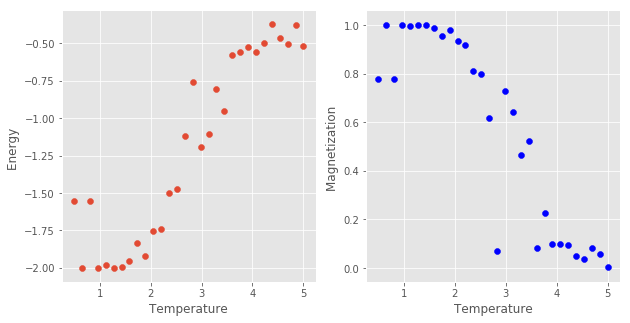

In [17]:
for t in range(Nt):
    print("Complete", t/Nt*100, '%\r', end='')             # мне пришлось тут кое-что поменять, т.к. вообще было всё странно
                                                           # функция makeFlip просто так была написана и ничему не присваивалась
    Esum = 0
    Msum = 0                                               # поэтому теперь в каждом цикле по i первая строчка другая;
    state = getInitialState(N)
    
    for i in range(eqSteps):         # установление статистического равновесия
        state = makeFlip(T[t], state)          

    for i in range(steps):           # суммирование по разным состояниям близким к равновеснсому
        state = makeFlip(T[t], state)          
        Esum += getEnergy(state)       
        Msum += getMagnetization(state) 

    E[t] = Esum / (steps * N * N)
    M[t] = Msum / (steps * N * N)

print("Done              \r", end='')

_, ax = plt.subplots(1,2,figsize=(10, 5));

ax[0].scatter(T, E)
ax[0].set_xlabel("Temperature");
ax[0].set_ylabel("Energy ");

ax[1].scatter(T, abs(M), color = 'blue')
ax[1].set_xlabel("Temperature"); 
ax[1].set_ylabel("Magnetization ");

Интерпретируйте с точки зрения физики полученные графики. Описывают ли они поведение ферромагнетиков и фазовые переходы?

Если выкинуть некоторые точки, то можно заметить, что энергия растет с ростом T(что, вроде как, очевидно, т.к. с ростом T всё тяжелее спуститься в минимум энергии), а так же уменьшается общая намагниченность, т.е. спины всё более хаотично расположены

Такой резкий переход является фазовым переходом 2 рода. $M$ падает в два раза уже около $T = 3$, и это не просто так: в нашей модели вероятность уйти в невыгодное состояние это $\exp(-\frac{\delta E}{T})$, а для случайного начального состояния, средний модуль энергии в ячейке $\overline{|E|} = 1.5$ (*), тогда $\overline{|\delta E|} = 3$, т.к. просто умножить на 2

Но тогда $\exp(-\frac{\delta E}{T}) \approx \exp(-1) \approx 0.36$, т.е. вероятность становится не такой уж и маленькой, а при дальнейшем росте $T$ и вовсе $P \to 1$

(*) приложена картинка ниже, как рассчитывался средний модуль энергии

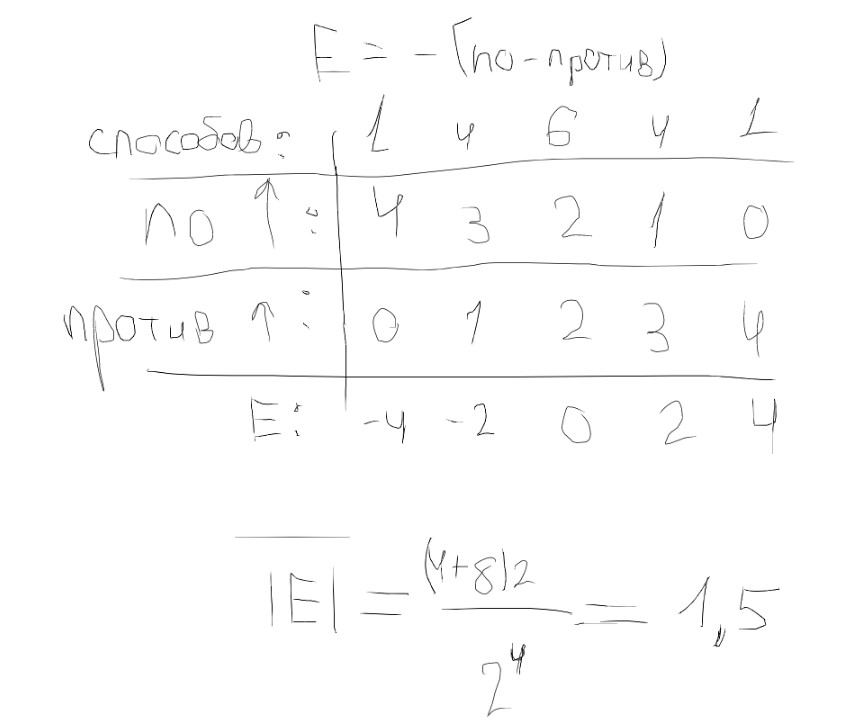

Задайте новое сосотояние системы с достаточно большим $N$ и визуализируйте его двумя цветами (например с помощью `plt.scatter`). Примените несколько раз к этому сосотоянию функциию makeFlip с низкой и с высокой температурами. Объясните наблюдаемое

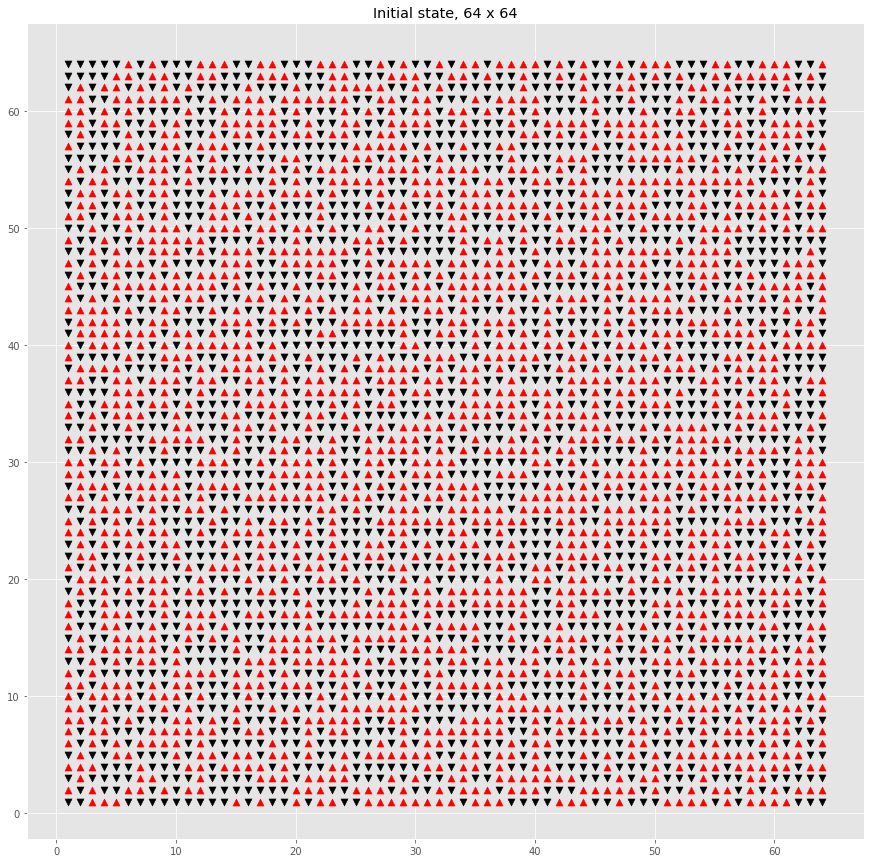

In [18]:
N = 64
state = getInitialState(N)             # самое простое будет изобразить все спины стрелочками, в matplotlib есть такие маркеры, плюс разные цвета

colors = np.array(['black', 'r'])
markers = np.array(['v', '^'])
matrix = (state > 0).astype(int)  # вместо -1 и 1 теперь спины 0 или 1, будет удобно строить

plt.figure(figsize=(15,15))
plt.title('Initial state, 64 x 64')
for i in range(N):
    for k in range(N):
        plt.scatter(k+1, i+1, c=colors[matrix[i, k]], marker=markers[matrix[i, k]], s=50)

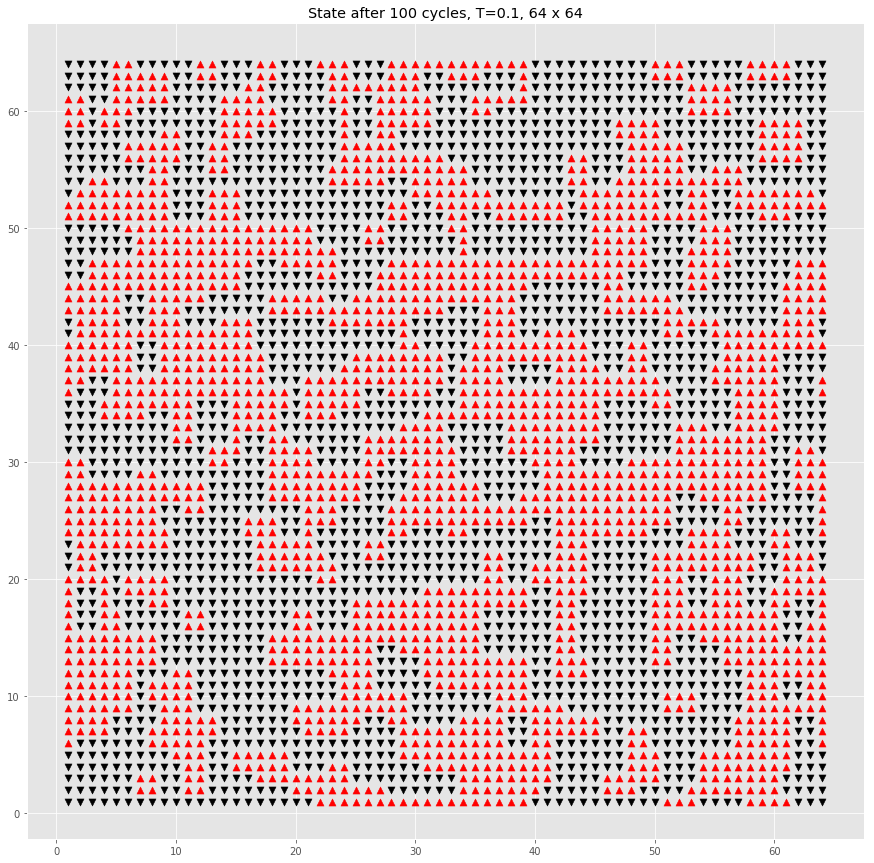

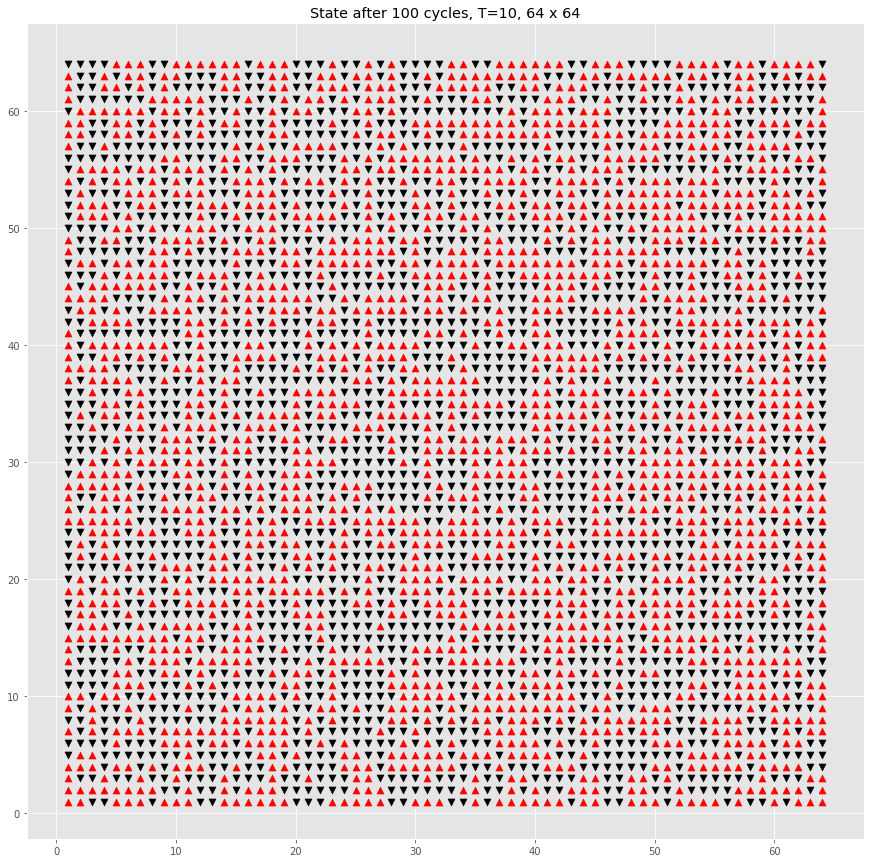

In [20]:
#                                         начальное положение у них одинаковое, в нем не выделяется ничего необычного
state_small = state
for i in range(100):
    state_small = makeFlip(0.1, state_small)   # покрутим для малой T
matrix = (state_small > 0).astype(int)

plt.figure(figsize=(15,15))
plt.title('State after 100 cycles, T=0.1, 64 x 64')
for i in range(N):
    for k in range(N):
        plt.scatter(k+1, i+1, c=colors[matrix[i, k]], marker=markers[matrix[i, k]], s=50)


state_large = state

for i in range(100):
    state_large = makeFlip(10, state_large)   # покрутим для большой T
matrix = (state_large > 0).astype(int)

plt.figure(figsize=(15,15))
plt.title('State after 100 cycles, T=10, 64 x 64')
for i in range(N):
    for k in range(N):
        plt.scatter(k+1, i+1, c=colors[matrix[i, k]], marker=markers[matrix[i, k]], s=50)


Можно заметить, что при малой T, отчетливо разглядыаются "доменные зоны", т.е. скопления спинов, направленных в одну сторону, а при высокой T всё разбросано хаотично, и какого-то pattern'а не наблюдается, либо эти зоны очень маленькие по сравнению со всей сеткой, поэтому их тяжело назвать доменами